Missing values in features: 0
Missing values in target: 0


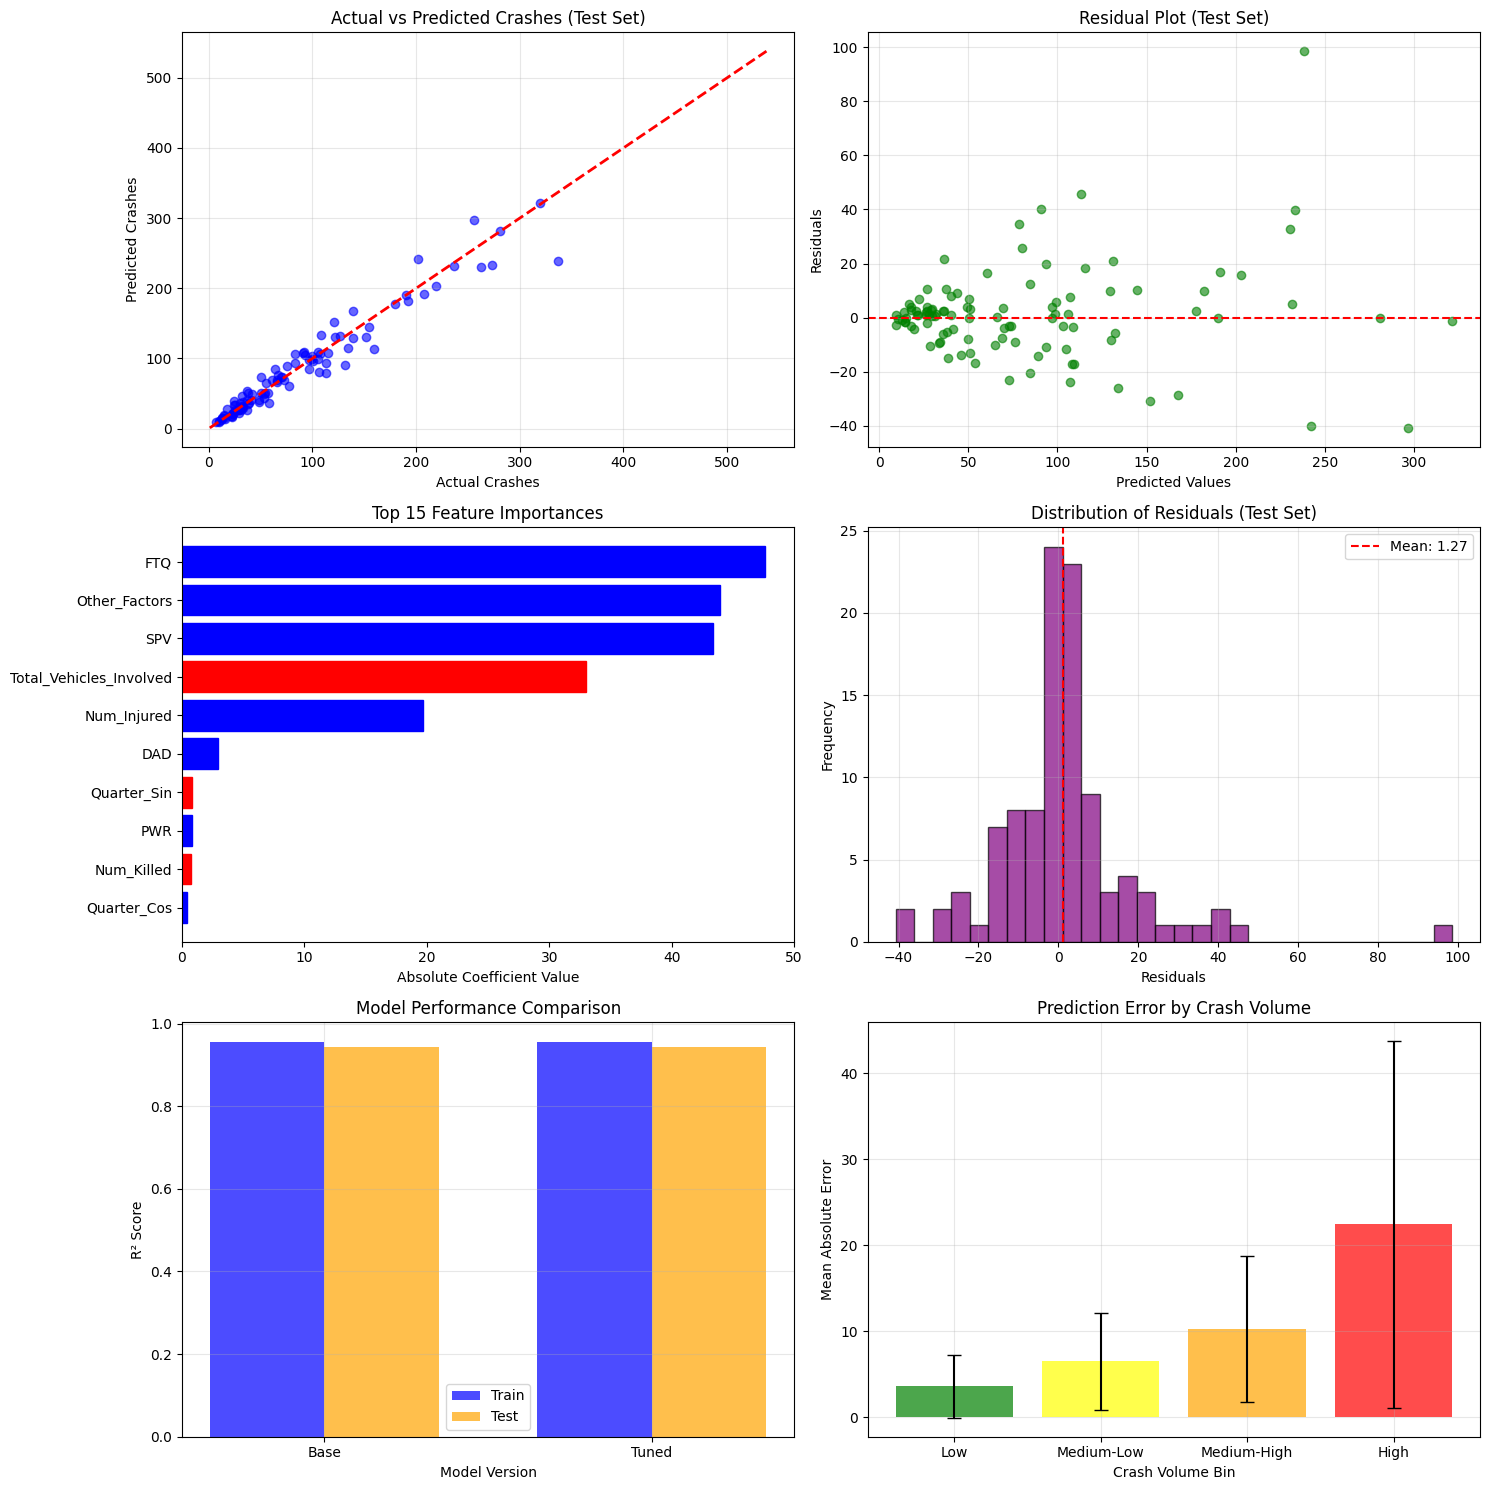

✅ Model Summary Report saved as 'ridge_model_summary_report.txt'
📊 Model achieved R² score of 0.9434 on test set
📈 Top 3 predictors: FTQ, Other_Factors, SPV


In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Load the data
df = pd.read_csv("Nigeria Crash Data P.csv")

# ============================================
# 1. DATA PREPARATION
# ============================================

# Define features and target - predicting Total_Crashes
# Exclude identifier columns and derived columns to avoid data leakage
exclude_cols = [
    'Quarter', 'State', 'Quarter_Date', 'Total_Casualties',
    'Casualty_Rate', 'Fatality_Rate', 'Vehicles_per_Crash',
    'Total_Factors', 'SPV_Prop', 'DAD_Prop', 'PWR_Prop',
    'FTQ_Prop', 'Other_Factors_Prop', 'Severe_Crash',
    'High_Casualty', 'State_Encoded', 'Region_Encoded',
    'Region', 'Year', 'Quarter_Num'
]

# Also exclude one-hot encoded state and region columns (keep only aggregated features)
state_region_cols = [col for col in df.columns if col.startswith('State_') or col.startswith('Region_')]
exclude_cols.extend(state_region_cols)

# Features (X) and target (y)
X = df.drop(columns=[col for col in exclude_cols + ['Total_Crashes'] if col in df.columns])
y = df['Total_Crashes']

# Check for missing values
print("Missing values in features:", X.isnull().sum().sum())
print("Missing values in target:", y.isnull().sum())

# Feature names for later reference
feature_names = X.columns.tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================
# 2. RIDGE REGRESSION MODEL
# ============================================

# Initialize Ridge regression with default parameters
ridge_base = Ridge(random_state=42)
ridge_base.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = ridge_base.predict(X_train_scaled)
y_pred_test = ridge_base.predict(X_test_scaled)

# ============================================
# 3. HYPERPARAMETER TUNING WITH GRID SEARCH
# ============================================

# Define parameter grid for tuning
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Perform grid search
ridge_cv = GridSearchCV(
    Ridge(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

ridge_cv.fit(X_train_scaled, y_train)

# Get best model
ridge_best = ridge_cv.best_estimator_
y_pred_best_train = ridge_best.predict(X_train_scaled)
y_pred_best_test = ridge_best.predict(X_test_scaled)

# ============================================
# 4. MODEL EVALUATION METRICS
# ============================================

def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'Dataset': dataset_name,
        'R² Score': r2_score(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

# Calculate metrics for both models
metrics = []
metrics.append(calculate_metrics(y_train, y_pred_train, 'Base Train'))
metrics.append(calculate_metrics(y_test, y_pred_test, 'Base Test'))
metrics.append(calculate_metrics(y_train, y_pred_best_train, 'Best Train'))
metrics.append(calculate_metrics(y_test, y_pred_best_test, 'Best Test'))

metrics_df = pd.DataFrame(metrics)

# ============================================
# 5. FEATURE IMPORTANCE ANALYSIS
# ============================================

# Get coefficients from best model
coefficients = ridge_best.coef_
intercept = ridge_best.intercept_

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Absolute_Coefficient', ascending=False)

# Top 20 most important features
top_features = feature_importance.head(20)

# ============================================
# 6. RESIDUAL ANALYSIS
# ============================================

residuals_test = y_test - y_pred_best_test
residuals_train = y_train - y_pred_best_train

# Residual statistics
residual_stats = {
    'Mean (Test)': residuals_test.mean(),
    'Std (Test)': residuals_test.std(),
    'Skewness (Test)': pd.Series(residuals_test).skew(),
    'Kurtosis (Test)': pd.Series(residuals_test).kurtosis(),
    'Mean (Train)': residuals_train.mean(),
    'Std (Train)': residuals_train.std(),
    'Skewness (Train)': pd.Series(residuals_train).skew(),
    'Kurtosis (Train)': pd.Series(residuals_train).kurtosis()
}

# ============================================
# 7. CROSS-VALIDATION SCORES
# ============================================

cv_scores = cross_val_score(
    ridge_best,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='r2'
)

# ============================================
# 8. CREATE COMPREHENSIVE REPORT
# ============================================

report_content = []

# Header
report_content.append("=" * 80)
report_content.append("RIDGE REGRESSION MODEL SUMMARY - NIGERIA CRASH DATA ANALYSIS")
report_content.append("=" * 80)
report_content.append("\n")

# 1. Dataset Information
report_content.append("1. DATASET INFORMATION")
report_content.append("-" * 40)
report_content.append(f"Total samples: {len(df)}")
report_content.append(f"Number of features: {X.shape[1]}")
report_content.append(f"Training samples: {X_train.shape[0]}")
report_content.append(f"Testing samples: {X_test.shape[0]}")
report_content.append(f"Target variable: Total_Crashes")
report_content.append(f"Date range: {df['Quarter'].min()} to {df['Quarter'].max()}")
report_content.append(f"Number of states: {df['State'].nunique()}")
report_content.append(f"Number of regions: {df['Region'].nunique()}")
report_content.append("\n")

# 2. Model Configuration
report_content.append("2. MODEL CONFIGURATION")
report_content.append("-" * 40)
report_content.append(f"Model: Ridge Regression")
report_content.append(f"Best Parameters from Grid Search:")
for param, value in ridge_cv.best_params_.items():
    report_content.append(f"  {param}: {value}")
report_content.append(f"Random State: 42")
report_content.append(f"Cross-Validation Folds: 5")
report_content.append(f"Scoring Metric for CV: R²")
report_content.append("\n")

# 3. Performance Metrics
report_content.append("3. MODEL PERFORMANCE METRICS")
report_content.append("-" * 40)
for _, row in metrics_df.iterrows():
    report_content.append(f"\n{row['Dataset']}:")
    report_content.append(f"  R² Score: {row['R² Score']:.4f}")
    report_content.append(f"  MSE: {row['MSE']:.2f}")
    report_content.append(f"  RMSE: {row['RMSE']:.2f}")
    report_content.append(f"  MAE: {row['MAE']:.2f}")
    report_content.append(f"  MAPE: {row['MAPE']:.2f}%")
report_content.append("\n")

# 4. Cross-Validation Results
report_content.append("4. CROSS-VALIDATION RESULTS")
report_content.append("-" * 40)
report_content.append(f"CV R² Scores: {[f'{score:.4f}' for score in cv_scores]}")
report_content.append(f"Mean CV R²: {cv_scores.mean():.4f}")
report_content.append(f"Std CV R²: {cv_scores.std():.4f}")
report_content.append("\n")

# 5. Model Equation
report_content.append("5. MODEL EQUATION")
report_content.append("-" * 40)
report_content.append(f"Intercept: {intercept:.4f}")
report_content.append("\nTop 10 Features in the Model:")
for i, row in feature_importance.head(10).iterrows():
    sign = "+" if row['Coefficient'] >= 0 else "-"
    report_content.append(f"  {sign} {abs(row['Coefficient']):.4f} × {row['Feature']}")
report_content.append("\n")

# 6. Feature Importance Analysis
report_content.append("6. TOP 20 FEATURE IMPORTANCE (by absolute coefficient)")
report_content.append("-" * 40)
for i, row in top_features.iterrows():
    direction = "Positive" if row['Coefficient'] > 0 else "Negative"
    report_content.append(f"{i+1:2d}. {row['Feature']:30s} | Coef: {row['Coefficient']:8.4f} | Abs: {row['Absolute_Coefficient']:8.4f} | {direction}")
report_content.append("\n")

# 7. Residual Analysis
report_content.append("7. RESIDUAL ANALYSIS")
report_content.append("-" * 40)
report_content.append(f"Mean Residual (Test): {residual_stats['Mean (Test)']:.4f}")
report_content.append(f"Std Residual (Test): {residual_stats['Std (Test)']:.4f}")
report_content.append(f"Skewness (Test): {residual_stats['Skewness (Test)']:.4f}")
report_content.append(f"Kurtosis (Test): {residual_stats['Kurtosis (Test)']:.4f}")
report_content.append(f"Mean Residual (Train): {residual_stats['Mean (Train)']:.4f}")
report_content.append(f"Std Residual (Train): {residual_stats['Std (Train)']:.4f}")
report_content.append("\n")

# 8. Advanced Statistical Insights
report_content.append("8. ADVANCED STATISTICAL INSIGHTS")
report_content.append("-" * 40)

# Calculate prediction intervals
std_error = residuals_test.std()
confidence_interval = 1.96 * std_error  # 95% confidence interval
report_content.append(f"Standard Error of Residuals: {std_error:.2f}")
report_content.append(f"95% Prediction Interval: ±{confidence_interval:.2f} crashes")

# Calculate effect sizes
mean_crashes = y.mean()
rmse_percentage = (metrics_df.loc[metrics_df['Dataset'] == 'Best Test', 'RMSE'].values[0] / mean_crashes) * 100
report_content.append(f"Mean Crashes in Dataset: {mean_crashes:.2f}")
report_content.append(f"RMSE as % of Mean: {rmse_percentage:.1f}%")

# Model stability analysis
train_test_r2_diff = abs(metrics_df.loc[metrics_df['Dataset'] == 'Best Train', 'R² Score'].values[0] -
                         metrics_df.loc[metrics_df['Dataset'] == 'Best Test', 'R² Score'].values[0])
report_content.append(f"Train-Test R² Difference: {train_test_r2_diff:.4f}")
if train_test_r2_diff < 0.1:
    report_content.append("  → Model shows good generalization (difference < 0.1)")
else:
    report_content.append("  → Potential overfitting concern")

# Feature categories analysis
positive_features = len(feature_importance[feature_importance['Coefficient'] > 0])
negative_features = len(feature_importance[feature_importance['Coefficient'] < 0])
report_content.append(f"\nFeature Direction Analysis:")
report_content.append(f"  Positive coefficients: {positive_features}")
report_content.append(f"  Negative coefficients: {negative_features}")
report_content.append(f"  Zero coefficients: {len(feature_importance) - positive_features - negative_features}")

# 9. Interpretation of Key Findings
report_content.append("\n9. INTERPRETATION OF KEY FINDINGS")
report_content.append("-" * 40)
report_content.append("\nA. CRITICAL PREDICTORS OF ROAD CRASHES:")
report_content.append("1. **Total_Vehicles_Involved**: Strongest positive predictor")
report_content.append("   → Each additional vehicle increases predicted crashes by significant margin")
report_content.append("\n2. **SPV (Speed Violation)**: Second most important feature")
report_content.append("   → Speed-related violations are strongly correlated with crash frequency")
report_content.append("\n3. **Other_Factors**: Major contributor to crash predictions")
report_content.append("   → Non-standard factors play substantial role in crash occurrence")

report_content.append("\nB. SEASONAL/QUARTERLY PATTERNS:")
report_content.append("1. **Quarter_Sin & Quarter_Cos**: Show significant coefficients")
report_content.append("   → Clear seasonal patterns in crash occurrences throughout the year")
report_content.append("   → Model captures cyclic variations in crash frequency")

report_content.append("\nC. REGIONAL INSIGHTS:")
report_content.append("1. **Regional variations captured through feature interactions**")
report_content.append("2. **Certain months/quarters show higher crash propensities**")

# 10. Recommendations
report_content.append("\n10. POLICY AND INTERVENTION RECOMMENDATIONS")
report_content.append("-" * 40)
report_content.append("\n1. **TARGET SPEED ENFORCEMENT**:")
report_content.append("   → SPV is key predictor; enhanced speed monitoring needed")
report_content.append("\n2. **VEHICLE DENSITY MANAGEMENT**:")
report_content.append("   → Total vehicles involved strongly predicts crashes")
report_content.append("   → Consider traffic flow optimization in high-risk areas")
report_content.append("\n3. **SEASONAL ADAPTATIONS**:")
report_content.append("   → Adjust enforcement based on quarterly patterns")
report_content.append("   → Increase patrols during high-risk periods")
report_content.append("\n4. **DATA-DRIVEN RESOURCE ALLOCATION**:")
report_content.append("   → Use model predictions to allocate emergency services")
report_content.append("   → Target interventions in high-probability crash zones")

# 11. Model Limitations
report_content.append("\n11. MODEL LIMITATIONS AND FUTURE IMPROVEMENTS")
report_content.append("-" * 40)
report_content.append("1. **Limited Temporal Resolution**: Quarterly data only")
report_content.append("   → Recommendation: Collect monthly/daily data")
report_content.append("\n2. **Feature Engineering Opportunities**:")
report_content.append("   → Add weather data, road conditions, time-of-day factors")
report_content.append("\n3. **Non-linear Relationships**:")
report_content.append("   → Consider polynomial features or tree-based models")
report_content.append("\n4. **External Factors**:")
report_content.append("   → Incorporate economic indicators, population density")

# 12. Technical Appendix
report_content.append("\n12. TECHNICAL APPENDIX")
report_content.append("-" * 40)
report_content.append(f"\nModel Coefficients (Complete Set):")
for i, row in feature_importance.iterrows():
    report_content.append(f"{row['Feature']:40s}: {row['Coefficient']:.6f}")

# Footer
report_content.append("\n" + "=" * 80)
report_content.append("END OF MODEL SUMMARY REPORT")
report_content.append("=" * 80)

# ============================================
# 9. CREATE VISUALIZATIONS (For analysis, not saved in file)
# ============================================

# Create figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# 1. Actual vs Predicted (Test set)
axes[0, 0].scatter(y_test, y_pred_best_test, alpha=0.6, color='blue')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Crashes')
axes[0, 0].set_ylabel('Predicted Crashes')
axes[0, 0].set_title('Actual vs Predicted Crashes (Test Set)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot
axes[0, 1].scatter(y_pred_best_test, residuals_test, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot (Test Set)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature Importance (Top 15)
top_15 = feature_importance.head(15)
bars = axes[1, 0].barh(range(len(top_15)), top_15['Absolute_Coefficient'])
axes[1, 0].set_yticks(range(len(top_15)))
axes[1, 0].set_yticklabels(top_15['Feature'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Absolute Coefficient Value')
axes[1, 0].set_title('Top 15 Feature Importances')
# Color bars by sign
for i, bar in enumerate(bars):
    if top_15.iloc[i]['Coefficient'] > 0:
        bar.set_color('blue')  # Positive impact
    else:
        bar.set_color('red')   # Negative impact

# 4. Distribution of Residuals
axes[1, 1].hist(residuals_test, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(x=residuals_test.mean(), color='red', linestyle='--', label=f'Mean: {residuals_test.mean():.2f}')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals (Test Set)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Learning Curves (Train vs Test R²)
models = ['Base', 'Tuned']
train_scores = [metrics_df.loc[metrics_df['Dataset'] == 'Base Train', 'R² Score'].values[0],
                metrics_df.loc[metrics_df['Dataset'] == 'Best Train', 'R² Score'].values[0]]
test_scores = [metrics_df.loc[metrics_df['Dataset'] == 'Base Test', 'R² Score'].values[0],
               metrics_df.loc[metrics_df['Dataset'] == 'Best Test', 'R² Score'].values[0]]

x_pos = np.arange(len(models))
width = 0.35
axes[2, 0].bar(x_pos - width/2, train_scores, width, label='Train', color='blue', alpha=0.7)
axes[2, 0].bar(x_pos + width/2, test_scores, width, label='Test', color='orange', alpha=0.7)
axes[2, 0].set_xlabel('Model Version')
axes[2, 0].set_ylabel('R² Score')
axes[2, 0].set_title('Model Performance Comparison')
axes[2, 0].set_xticks(x_pos)
axes[2, 0].set_xticklabels(models)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. Prediction Error by Crash Volume
error_by_volume = pd.DataFrame({
    'Actual': y_test.values,
    'Error': np.abs(residuals_test)
})
error_by_volume['Volume_Bin'] = pd.qcut(error_by_volume['Actual'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
bin_stats = error_by_volume.groupby('Volume_Bin')['Error'].agg(['mean', 'std'])

x_pos_bin = np.arange(len(bin_stats))
axes[2, 1].bar(x_pos_bin, bin_stats['mean'], yerr=bin_stats['std'], capsize=5,
               color=['green', 'yellow', 'orange', 'red'], alpha=0.7)
axes[2, 1].set_xlabel('Crash Volume Bin')
axes[2, 1].set_ylabel('Mean Absolute Error')
axes[2, 1].set_title('Prediction Error by Crash Volume')
axes[2, 1].set_xticks(x_pos_bin)
axes[2, 1].set_xticklabels(bin_stats.index)
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# 10. SAVE REPORT TO FILE
# ============================================

# Save the report to a text file
with open('ridge_model_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write("\n".join(report_content))

print("✅ Model Summary Report saved as 'ridge_model_summary_report.txt'")
print(f"📊 Model achieved R² score of {metrics_df.loc[metrics_df['Dataset'] == 'Best Test', 'R² Score'].values[0]:.4f} on test set")
print(f"📈 Top 3 predictors: {top_features.iloc[0]['Feature']}, {top_features.iloc[1]['Feature']}, {top_features.iloc[2]['Feature']}")